# Infilling the Shell Energy Model

Applying infilling to the Shell energy model, Sky, which contains only CO2 from Energy and Industry. 

You will need to install a silicone version that includes convenience_changes from https://github.com/znicholls/silicone/ in order to run this code. Note that the first runthrough will require collecting large amounts of data and hence will be slow. 

## Imports

In [1]:
import os.path

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np

import silicone.multiple_infillers as mi
import silicone.database_crunchers as cr
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    _make_interpolator,
    _make_wide_db,
    download_or_load_sr15,
)


<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


## Our data

Here we will infill the  using the historic RCMIP data.

In [2]:
sr15_file = "./../Input/complete_sr15.csv"
all_models = [
    'AIM/CGE 2.0', 'AIM/CGE 2.1', 'C-ROADS-5.005', 'GCAM 4.2', 'GENeSYS-MOD 1.0', 
    'IEA Energy Technology Perspective Model 2017', 'IEA World Energy Model 2017', 
    'IMAGE 3.0.1', 'IMAGE 3.0.2', 'MERGE-ETL 6.0', 'MESSAGE V.3', 'MESSAGE-GLOBIOM 1.0', 
    'MESSAGEix-GLOBIOM 1.0', 'POLES ADVANCE', 'POLES CD-LINKS', 'POLES EMF33', 'REMIND 1.5', 
    'REMIND 1.7', 'REMIND-MAgPIE 1.5', 'REMIND-MAgPIE 1.7-3.0', 
    'Shell World Energy Model 2018', 'WITCH-GLOBIOM 3.1', 'WITCH-GLOBIOM 4.2', 'WITCH-GLOBIOM 4.4'
]
download_or_load_sr15(sr15_file, all_models)    

# We are only interested in the worldwide record
df = pyam.IamDataFrame(sr15_file).filter(region="World") 
df.head()

pyam.utils - INFO: Reading `./../Input/complete_sr15.csv`
pyam.utils - INFO: Reading `./../Input/complete_sr15.csv`


,model,scenario,region,variable,unit,year,meta,subannual,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2005,0,0.0,8.3367
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2010,0,0.0,7.6408
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2015,0,0.0,7.2724
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2020,0,0.0,7.0752
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2025,0,0.0,5.8486


### Comparing timelines
In order to establish the best infilling method, we should see how it compares to the other available trend lines. We plot the Sky model in black.


In [3]:
model_to_infill = 'Shell World Energy Model 2018'
df_to_infill = df.filter(model=model_to_infill)
lead = ["Emissions|CO2|Energy and Industrial Processes"]

In [4]:
df_to_infill.data["year"].unique()

array([2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055,
       2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100], dtype=int64)

We see that the CO2 results are well within the expected range. This means we can use an absolute value infilling method. We also see that there are not many paths with a very similar curve. Temporal consistency would point us towards using the RMS closest method, conservatism of the estimate would point towards using the quantile rolling window method. We shall see how the methods vary. 

In [5]:
quantile_infilled = mi.infill_all_required_variables(
    df_to_infill,
    df,
    variable_leaders=lead,
    required_variables_list=None, # This will automatically use the complete set of variables
    cruncher=cr.DatabaseCruncherQuantileRollingWindows,
    output_timesteps=df_to_infill.data["year"].unique(),
    infilled_data_prefix=None,
    to_fill_old_prefix=None,
    check_data_returned=False,
)

c:\users\rlamboll\constraincode\silicone\src\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:165: UserWarning: No data for ['Emissions|HFC|HFC245ca']
  warnings.warn(UserWarning("No data for {}".format(unavailable_variables)))
Filling required variables: 100%|██████████████████████████████████████████████████████| 22/22 [00:38<00:00,  1.74s/it]


The warning informs us that the database has no data for HFC245ca. The default behaviour is to infill it with 0s, but this may well not be the best choice - it is simply the most comparable with the existing database. 

In [6]:
quantile_infilled.filter(variable="*HFC245ca").data

,model,scenario,region,variable,unit,year,meta,subannual,value
200,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2005,0,0.0,0.0
201,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2010,0,0.0,0.0
202,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2015,0,0.0,0.0
203,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2020,0,0.0,0.0
204,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2025,0,0.0,0.0
205,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2030,0,0.0,0.0
206,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2035,0,0.0,0.0
207,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2040,0,0.0,0.0
208,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2045,0,0.0,0.0
209,Shell World Energy Model 2018,Sky,World,Emissions|HFC|HFC245ca,Mt CO2-equiv/yr,2050,0,0.0,0.0


Other data is infilled as expected

In [7]:
quantile_infilled.timeseries().head()

2005  \
model                         scenario region variable                                      unit      meta subannual                 
Shell World Energy Model 2018 Sky      World  Emissions|BC                                  Mt BC/yr  0    0.0            8.525072   
                                              Emissions|CH4                                 Mt CH4/yr 0    0.0          344.153046   
                                              Emissions|CO                                  Mt CO/yr  0    0.0          949.247293   
                                              Emissions|CO2|AFOLU                           Mt CO2/yr 0    0.0         4489.209767   
                                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr 0    0.0        28361.266440   

                                                                                                                              2010  \
model                         scenario region variable                                      unit      meta subannual                 
Shell World Energy Model 2018 Sky      World  Emissions|BC                                  Mt BC/yr  0    0.0            7.664163   
                                              Emissions|CH4                                 Mt CH4/yr 0    0.0          365.698535   
                                              Emissions|CO                                  Mt CO/yr  0    0.0          850.118475   
                                              Emissions|CO2|AFOLU                           Mt CO2/yr 0    0.0         3542.912663   
                                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr 0    0.0        32246.261640   

                                                                                                                              2015  \
model                         scenario region variable                                      unit      meta subannual                 
Shell World Energy Model 2018 Sky      World  Emissions|BC                                  Mt BC/yr  0    0.0            7.078800   
                                              Emissions|CH4                                 Mt CH4/yr 0    0.0          351.698432   
                                              Emissions|CO                                  Mt CO/yr  0    0.0          844.824685   
                                              Emissions|CO2|AFOLU                           Mt CO2/yr 0    0.0         4355.884422   
                                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr 0    0.0        33939.974860   

                                                                                                                              2020  \
model                         scenario region variable                                      unit      meta subannual                 
Shell World Energy Model 2018 Sky      World  Emissions|BC                                  Mt BC/yr  0    0.0            6.583354   
                                              Emissions|CH4                                 Mt CH4/yr 0    0.0          345.216157   
                                              Emissions|CO                                  Mt CO/yr  0    0.0          805.950997   
                                              Emissions|CO2|AFOLU                           Mt CO2/yr 0    0.0         4173.734676   
                                              Emissions|CO2|Energy and Industrial Processes Mt CO2/yr 0    0.0        35150.682170   

                                                                                                                              2025  \
model                         scenario region variable                                      unit      meta subannual                 
Shell World Energy Model 2018 Sky      World  Emissions|BC                                  Mt BC/yr  

This is now a complete dataset that we can process. 

In [8]:
quantile_infilled.variables()

0                                      Emissions|BC
1                                     Emissions|CH4
2                                      Emissions|CO
3                               Emissions|CO2|AFOLU
4     Emissions|CO2|Energy and Industrial Processes
5                              Emissions|HFC|HFC125
6                             Emissions|HFC|HFC134a
7                             Emissions|HFC|HFC143a
8                            Emissions|HFC|HFC227ea
9                               Emissions|HFC|HFC23
10                           Emissions|HFC|HFC245ca
11                              Emissions|HFC|HFC32
12                           Emissions|HFC|HFC43-10
13                                    Emissions|N2O
14                                    Emissions|NH3
15                                    Emissions|NOx
16                                     Emissions|OC
17                               Emissions|PFC|C2F6
18                              Emissions|PFC|C6F14
19          

We repeat the process for the other crunchers to compare results, starting with RMS closest. 

In [9]:
closest_infilled = mi.infill_all_required_variables(
    df_to_infill,
    df,
    variable_leaders=lead,
    required_variables_list=None, # This will automatically use the complete set of variables
    cruncher=cr.DatabaseCruncherRMSClosest,
    output_timesteps=df_to_infill.data["year"].unique(),
    infilled_data_prefix=None,
    to_fill_old_prefix=None,
    check_data_returned=False,
)

c:\users\rlamboll\constraincode\silicone\src\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:165: UserWarning: No data for ['Emissions|HFC|HFC245ca']
  warnings.warn(UserWarning("No data for {}".format(unavailable_variables)))
Filling required variables: 100%|██████████████████████████████████████████████████████| 22/22 [00:31<00:00,  1.42s/it]


In [10]:
closest_infilled.variables()

0                                      Emissions|BC
1                                     Emissions|CH4
2                                      Emissions|CO
3                               Emissions|CO2|AFOLU
4     Emissions|CO2|Energy and Industrial Processes
5                              Emissions|HFC|HFC125
6                             Emissions|HFC|HFC134a
7                             Emissions|HFC|HFC143a
8                            Emissions|HFC|HFC227ea
9                               Emissions|HFC|HFC23
10                           Emissions|HFC|HFC245ca
11                              Emissions|HFC|HFC32
12                           Emissions|HFC|HFC43-10
13                                    Emissions|N2O
14                                    Emissions|NH3
15                                    Emissions|NOx
16                                     Emissions|OC
17                               Emissions|PFC|C2F6
18                              Emissions|PFC|C6F14
19          

In [11]:
# It's most efficient to do the filtering outside the multiple infiller, rather than repeat it for every variable
df_spec = df.filter(model="REMIND-MAgPIE 1.5", scenario="SSP5*")
interp_spec_infilled = mi.infill_all_required_variables(
    df_to_infill,
    df_spec,
    variable_leaders=lead,
    required_variables_list=None, # This will automatically use the complete set of variables
    cruncher=cr.DatabaseCruncherLinearInterpolation,
    output_timesteps=df_to_infill.data["year"].unique(),
    infilled_data_prefix=None,
    to_fill_old_prefix=None,
    check_data_returned=False,
)

c:\users\rlamboll\constraincode\silicone\src\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:165: UserWarning: No data for ['Emissions|PFC|CF4', 'Emissions|PFC|C2F6', 'Emissions|PFC|C6F14', 'Emissions|HFC|HFC134a', 'Emissions|HFC|HFC143a', 'Emissions|HFC|HFC227ea', 'Emissions|HFC|HFC23', 'Emissions|HFC|HFC32', 'Emissions|HFC|HFC43-10', 'Emissions|HFC|HFC245ca', 'Emissions|HFC|HFC125', 'Emissions|SF6']
  warnings.warn(UserWarning("No data for {}".format(unavailable_variables)))
Filling required variables: 100%|██████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.19it/s]


In [12]:
# Using the unfiltered database allows us to find more variables, but will produce chaotic results below
interp_infilled = mi.infill_all_required_variables(
    df_to_infill,
    df,
    variable_leaders=lead,
    required_variables_list=None, # This will automatically use the complete set of variables
    cruncher=cr.DatabaseCruncherLinearInterpolation,
    output_timesteps=df_to_infill.data["year"].unique(),
    infilled_data_prefix=None,
    to_fill_old_prefix=None,
    check_data_returned=False,
)

c:\users\rlamboll\constraincode\silicone\src\silicone\multiple_infillers\infill_all_required_emissions_for_openscm.py:165: UserWarning: No data for ['Emissions|HFC|HFC245ca']
  warnings.warn(UserWarning("No data for {}".format(unavailable_variables)))
Filling required variables: 100%|██████████████████████████████████████████████████████| 22/22 [00:18<00:00,  1.20it/s]


In this case, many variables could not be found. 

In [13]:
interp_spec_infilled.variables()

0                                      Emissions|BC
1                                     Emissions|CH4
2                                      Emissions|CO
3                               Emissions|CO2|AFOLU
4     Emissions|CO2|Energy and Industrial Processes
5                              Emissions|HFC|HFC125
6                             Emissions|HFC|HFC134a
7                             Emissions|HFC|HFC143a
8                            Emissions|HFC|HFC227ea
9                               Emissions|HFC|HFC23
10                           Emissions|HFC|HFC245ca
11                              Emissions|HFC|HFC32
12                           Emissions|HFC|HFC43-10
13                                    Emissions|N2O
14                                    Emissions|NH3
15                                    Emissions|NOx
16                                     Emissions|OC
17                               Emissions|PFC|C2F6
18                              Emissions|PFC|C6F14
19          

Text(0.5, 0.98, 'Methane emissions infilled with different methods')

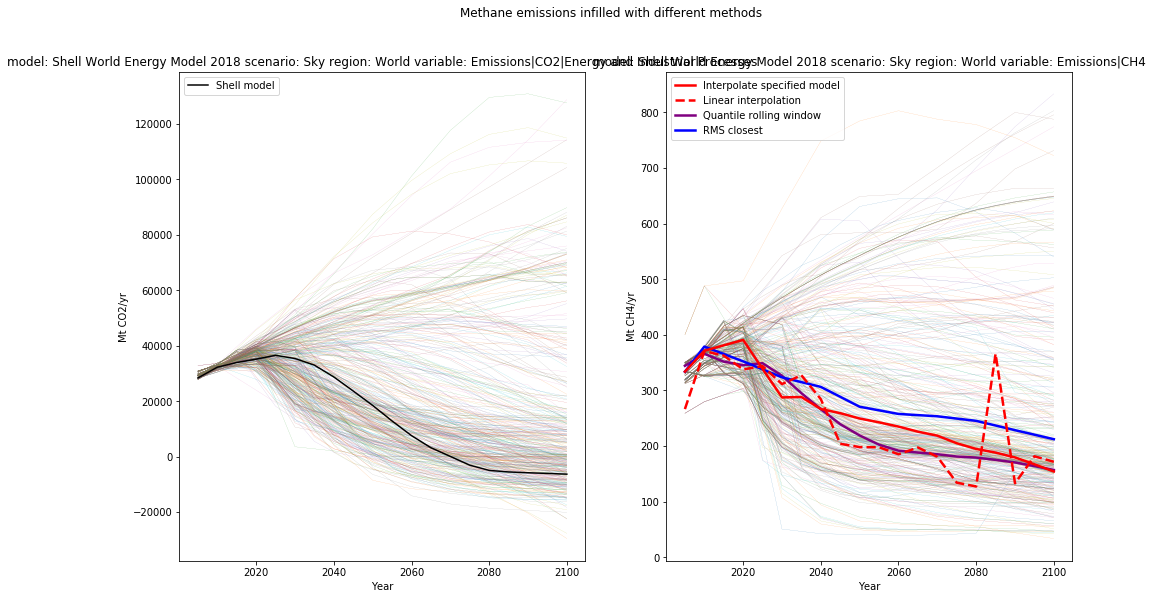

In [14]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
df.filter(variable=lead, year=df_to_infill.data["year"].unique()).line_plot(ax=ax, linewidth=0.1, label='_nolegend_')
df_to_infill.filter(variable=lead).line_plot(ax=ax, color="black", label="Shell model")
ax = fig.add_subplot(122)
df.filter(variable="Emissions|CH4", year=df_to_infill.data["year"].unique()).line_plot(ax=ax, linewidth=0.1, label='_nolegend_')
quantile_infilled.filter(variable="Emissions|CH4").line_plot(ax=ax, linewidth=2.5, color="purple", 
                                                             label="Quantile rolling window")
closest_infilled.filter(variable="Emissions|CH4").line_plot(ax=ax, color="blue", linewidth=2.5, label="RMS closest")
interp_spec_infilled.filter(variable="Emissions|CH4").line_plot(ax=ax, color="red", linewidth=2.5, 
                                                                label="Interpolate specified model")
interp_infilled.filter(variable="Emissions|CH4").line_plot(ax=ax, color="red", linewidth=2.5, 
                                                           label="Linear interpolation", linestyle="--")
fig.suptitle("Methane emissions infilled with different methods")

In [15]:
df.filter(variable="Emissions|HFC|HFC23", scenario="*SSP5*").models()

Series([], Name: model, dtype: object)